In [1]:
import numpy  as np 
import xarray as xr

import matplotlib.pyplot as plt
import plot
import matplotlib.patches as patches
import matplotlib

from xfrites.conn.conn_coh import _tf_decomp,_create_kernel, _smooth_spectra,conn_coherence_wav

In [2]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE=plot.set_plot_config()

#### Loading data

In [3]:
data = xr.load_dataarray("sample_data.nc")

In [4]:
#### Choosing pair of regions

In [5]:
area1 = 'a9/46D'
area2 = 'LIP'

In [6]:
lfp   = np.zeros((1,2,data.sizes["time"]))

In [7]:
lfp[0,0,:] = data.sel(roi=area1).values
lfp[0,1,:] = data.sel(roi=area2).values[0]

### Spectral analysis

#### Define parameters

In [8]:
# Smoothing windows
sm_times  = 500
sm_freqs  = 1
sm_kernel = "square"
decim     = 15

# Defining parameters
delta = 15       # Downsampling factor
mode  = 'morlet' # ("morlet", "mt_1", "mt_2")
foi   = np.array([
        [0.1, 6.],
        [6., 14.],
        [14., 26.],
        [26., 42.],
        [42., 80.]
            ])

n_freqs  = 50
freqs    = np.linspace(foi[0,0], foi[-1,1], n_freqs, endpoint=True)
n_cycles = freqs/2

#### Wavelet analysis

In [9]:
W = _tf_decomp(lfp, data.attrs["fsample"], freqs, n_cycles=n_cycles,mode=mode,
               decim=decim, kw_cwt={}, kw_mt={}, n_jobs=-1).squeeze()

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.3s finished


In [10]:
# Auto- and cross-spectra
Sxx = W[0,...]*np.conj(W[0,...])
Syy = W[1,...]*np.conj(W[1,...])
Sxy = W[0,...]*np.conj(W[1,...])

In [11]:
# Create smoothing kernel
kernel = _create_kernel(sm_times//decim, sm_freqs, kernel=sm_kernel)
# Smoothed auto- and cross-spectra 
sSxx = _smooth_spectra( W[0,...]*np.conj(W[0,...]), kernel )
sSyy = _smooth_spectra( W[1,...]*np.conj(W[1,...]), kernel )
sSxy = _smooth_spectra( W[0,...]*np.conj(W[1,...]), kernel )

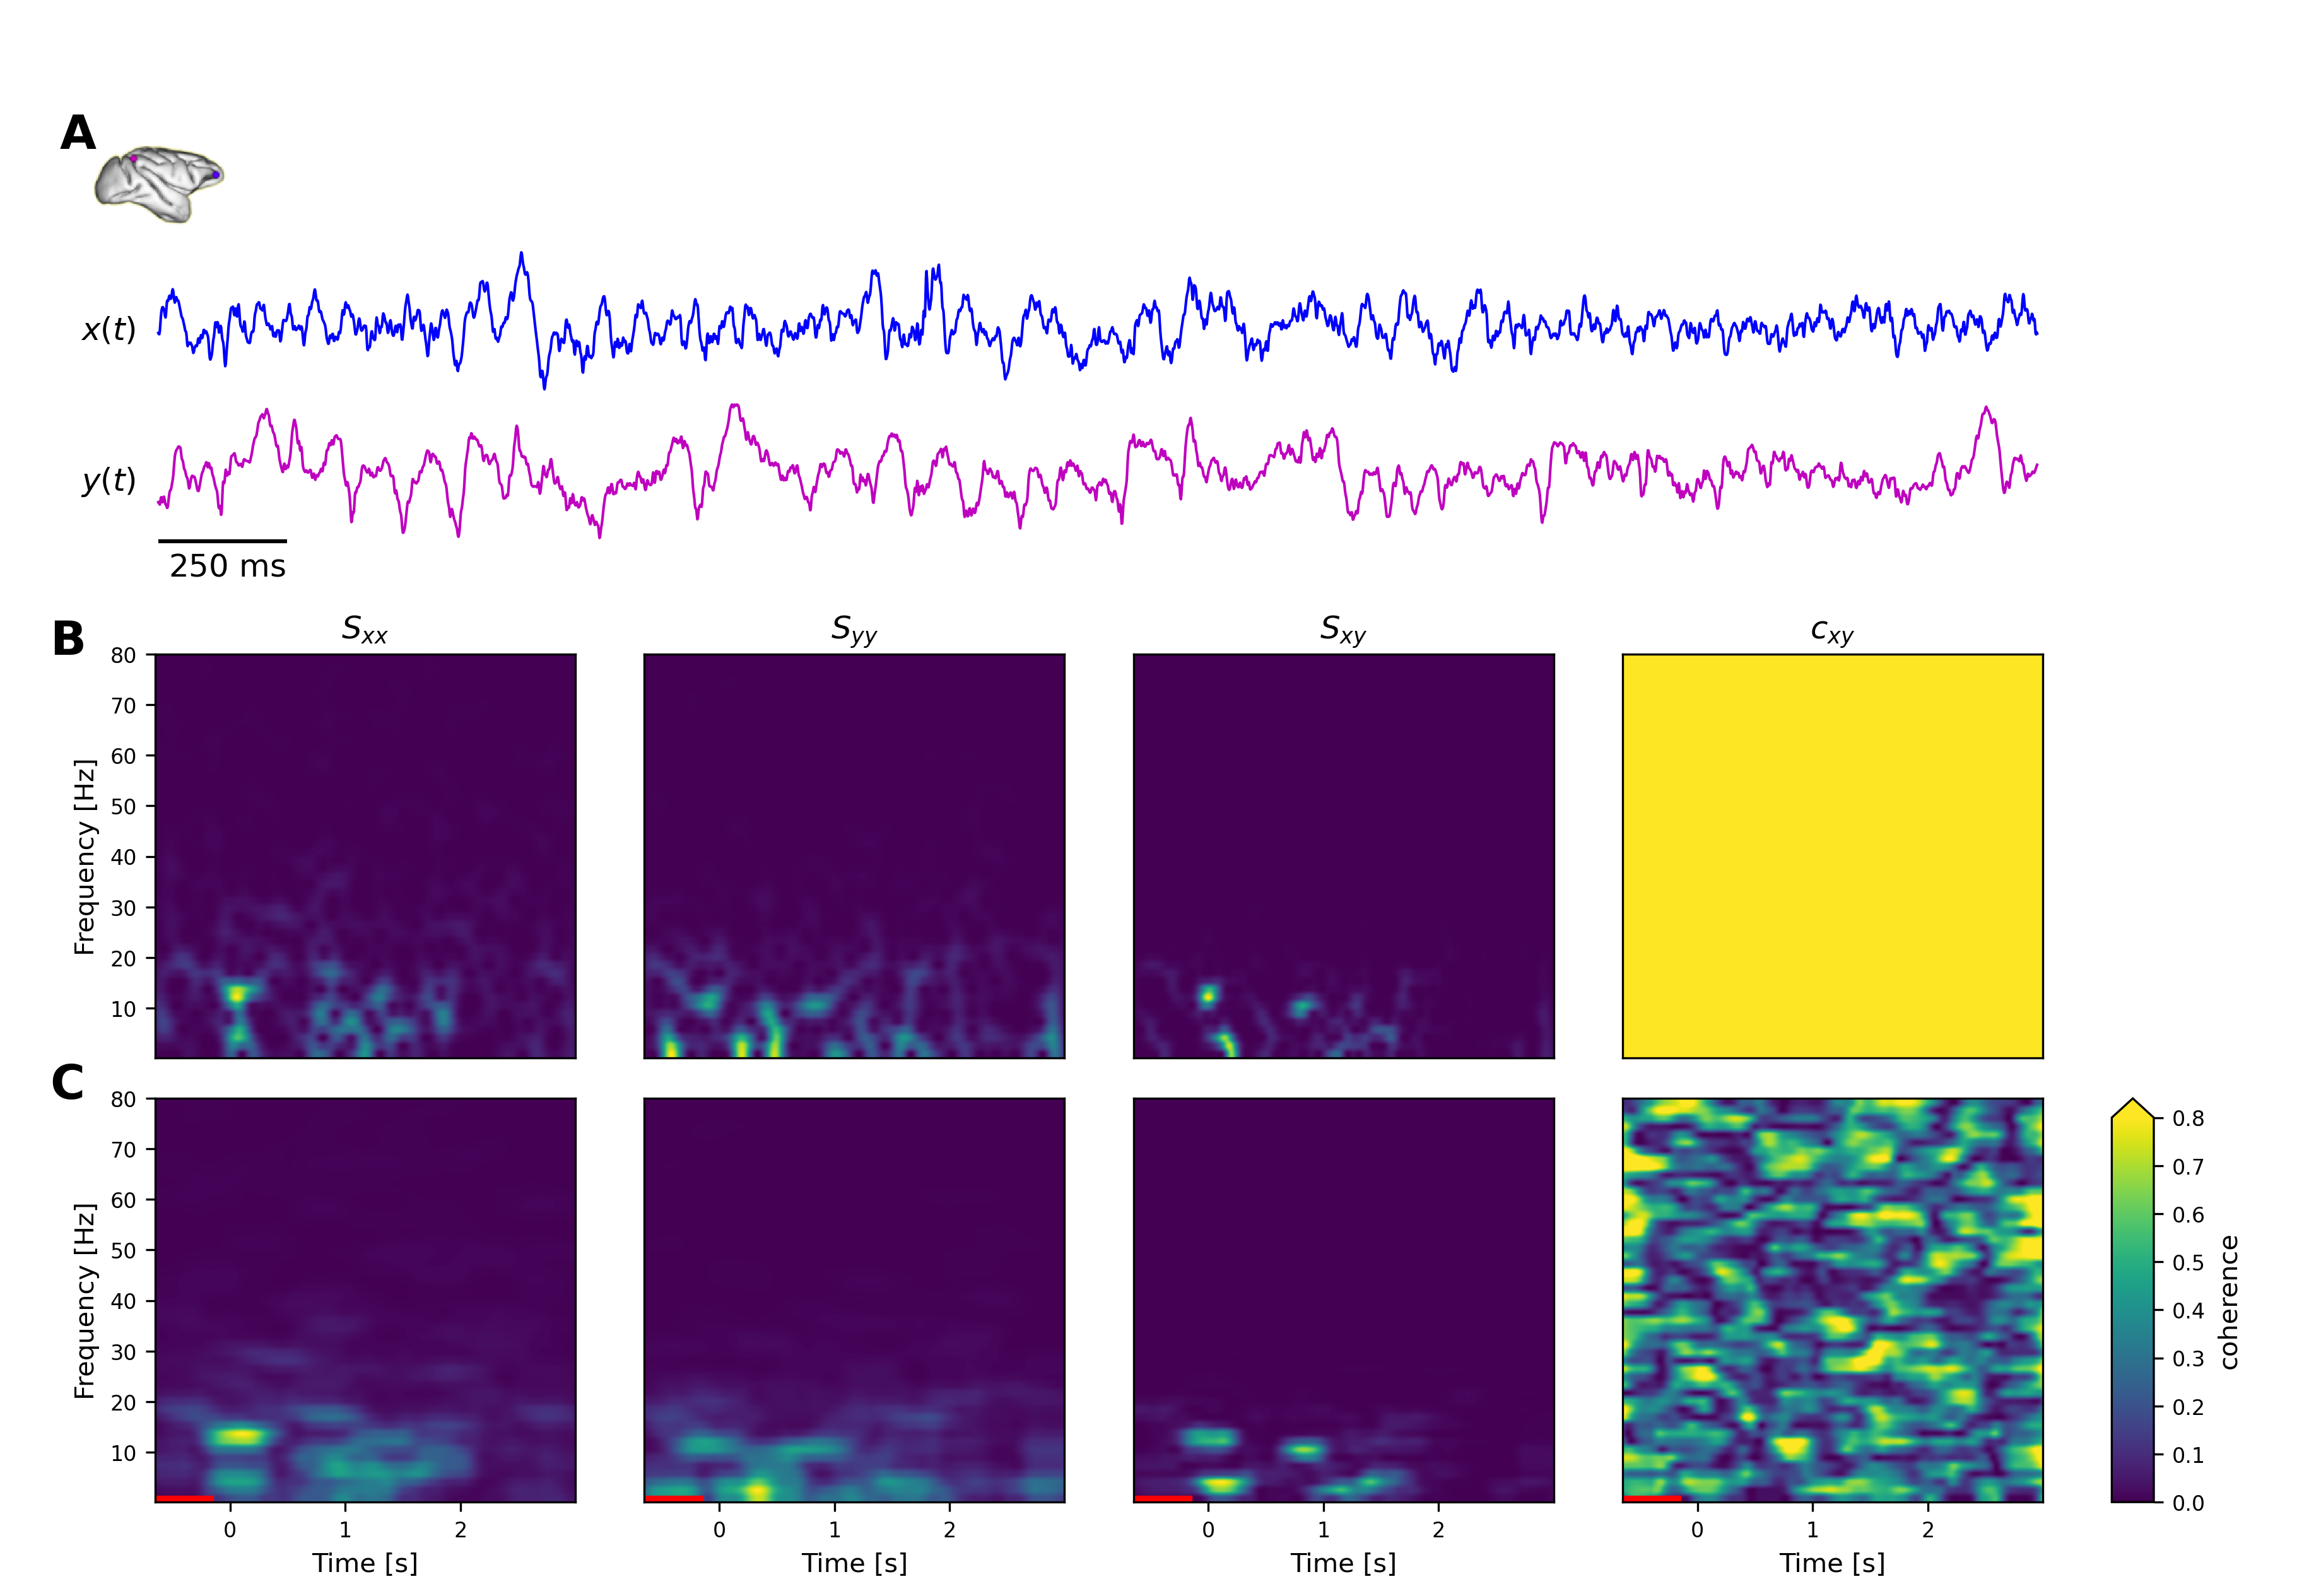

In [14]:
def plot_circles(ax):
    """
    Plot olympics circles to the given axes.
    """
    
    png = plt.imread('brain.png')
    plt.sca(ax)
    im = plt.imshow(png, interpolation='none')
    plt.axis('off')    
    pad = 1
    plt.xlim(-pad, png.shape[1]+pad)
    plt.ylim(png.shape[0]+pad, -pad)    


fig = plt.figure(figsize=(12, 8), dpi=300)

gs0 = fig.add_gridspec(nrows=1, ncols=10, left=0.02, right=0.97, wspace=0.1, bottom=0.86, top=0.92)
gs1 = fig.add_gridspec(nrows=2, ncols=1, left=0.02, right=0.93, wspace=0.1, hspace=0.01, bottom=0.65, top=0.85)
#gs2 = fig.add_gridspec(nrows=2, ncols=2, left=0.62, right=0.97, bottom=0.50, top=0.95)
gs3 = fig.add_gridspec(nrows=2, ncols=5, width_ratios=(1,1,1,1, 0.1), left=0.06, right=0.94, bottom=0.02, top=0.58, hspace=0.1)

# Brainskecth
ax0 = plt.subplot(gs0[0])
plot_circles(ax0)

# Panel A
ax1 = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[1])


plt.sca(ax1)
plt.plot(data.time, lfp[0,0], color = "b", lw=1)
plt.text(-0.8, -0.00002, r"$x(t)$", fontsize=BIGGER_SIZE)
plt.axis("off")
plt.sca(ax2)
plt.plot(data.time, lfp[0,1], color = "m", lw=1)
plt.text(-0.8, -0.00005, r"$y(t)$", fontsize=BIGGER_SIZE)
plt.hlines(-0.0002, data.time[0], data.time[0]+0.25, 'k')
plt.text(-0.63, -0.0003, r"$250$ ms", fontsize=BIGGER_SIZE)
plt.axis("off")


# Panel A

extent = [data.time.values[0],data.time.values[-1],
          freqs[0], freqs[-1]]

# Panel A
ax3 = plt.subplot(gs3[0])
ax4 = plt.subplot(gs3[1])
ax5 = plt.subplot(gs3[2])
ax6 = plt.subplot(gs3[3])
ax7 = plt.subplot(gs3[4])
ax8 = plt.subplot(gs3[5])
ax9 = plt.subplot(gs3[6])
ax10 = plt.subplot(gs3[7])
ax11 = plt.subplot(gs3[8])
ax12 = plt.subplot(gs3[9])


plt.sca(ax3)
plt.imshow(Sxx.real, aspect="auto", cmap="viridis", origin="lower", extent=extent)
plt.xticks([])
plt.ylabel("Frequency [Hz]")
plt.title(r"$S_{xx}$", fontsize=BIGGER_SIZE)
plt.sca(ax8)
plt.imshow(sSxx.real, aspect="auto", cmap="viridis", origin="lower", extent=extent)
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
rect = patches.Rectangle((data.time[0],freqs[0]), sm_times/1000, sm_freqs, color='r')
plt.gca().add_patch(rect)
plt.sca(ax4)
plt.imshow(Syy.real, aspect="auto", cmap="viridis", origin="lower", extent=extent)
plt.title(r"$S_{yy}$", fontsize=BIGGER_SIZE)
plt.yticks([])
plt.xticks([])
plt.sca(ax9)
plt.imshow(sSyy.real, aspect="auto", cmap="viridis", origin="lower", extent=extent)
plt.yticks([])
plt.xlabel("Time [s]")
rect = patches.Rectangle((data.time[0],freqs[0]), sm_times/1000, sm_freqs, color='r')
plt.gca().add_patch(rect)
plt.sca(ax5)
plt.imshow(np.abs(Sxy)**2, aspect="auto", cmap="viridis", origin="lower", extent=extent)
plt.title(r"$S_{xy}$", fontsize=BIGGER_SIZE)
plt.yticks([])
plt.xticks([])
plt.sca(ax10)
plt.imshow(np.abs(sSxy)**2, aspect="auto", cmap="viridis", origin="lower", extent=extent)
plt.xlabel("Time [s]")
plt.yticks([])
rect = patches.Rectangle((data.time[0],freqs[0]), sm_times/1000, sm_freqs, color='r')
plt.gca().add_patch(rect)

plt.sca(ax6)
plt.imshow(( np.abs(Sxy)**2/(Sxx*Syy) ).real, aspect="auto", cmap="viridis", origin="lower", extent=extent, vmin=0,vmax=.8)
plt.xticks([])
plt.yticks([])
plt.title(r"$c_{xy}$", fontsize=BIGGER_SIZE)
plt.sca(ax11)
plt.imshow(( np.abs(sSxy)**2/(sSxx*sSyy) ).real, aspect="auto", cmap="viridis", origin="lower", extent=extent,vmin=0, vmax=.8)
plt.yticks([])
plt.xlabel("Time [s]")
rect = patches.Rectangle((data.time[0],freqs[0]), sm_times/1000, sm_freqs, color='r')
plt.gca().add_patch(rect)

plt.sca(ax7)
plt.axis("off")

norm = matplotlib.colors.Normalize(vmin=0, vmax=.8)
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(cmap=matplotlib.cm.viridis, norm=norm), cax=ax12, extend="max", shrink=0.1)
cbar.ax.set_ylabel("coherence", rotation='vertical')

plot.add_panel_letters(fig, axes=[ax0, ax3, ax8], fontsize=18,
                       xpos=[-0.2,-0.25,-0.25], ypos=[0.9, 1, 1] );

bg = plot.Background(visible=False)

plt.savefig("coh.pdf", dpi=600, bbox_inches='tight')